In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

In [2]:
ab_data = pd.read_csv('ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


##### У таблицы следующие поля:
* user_id - идентификатор пользователя, зашедшего на сайт
* timestamp - дата события
* group - группа теста (контрольная или тестовая)
* converted - совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


В наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. 

In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

Получим показатель конверсии в группах на каждый день.

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Рассчитаем конверсию на каждый день.

In [7]:
daily_data['conversion'] = daily_data['converted']/daily_data['users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


Построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

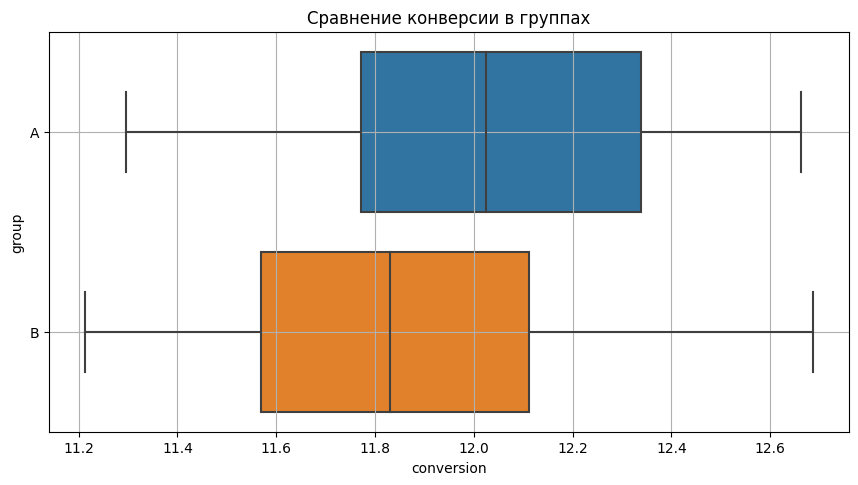

In [8]:
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
ax.set_title('Сравнение конверсии в группах')
ax.grid(True);

* медианное значение ежедневной конверсии в группе А, выше, чем в группе B. 
* разброс конверсии в группе B несколько больше, чем в группе A.

Вычислим средний и медианный показатель конверсии в контрольной и тестовой группе, чтобы убедиться, что нет выбросов.

In [9]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают.

Посмотрим, как изменялись показатели ежедневной конверсии в каждой группе во времени.

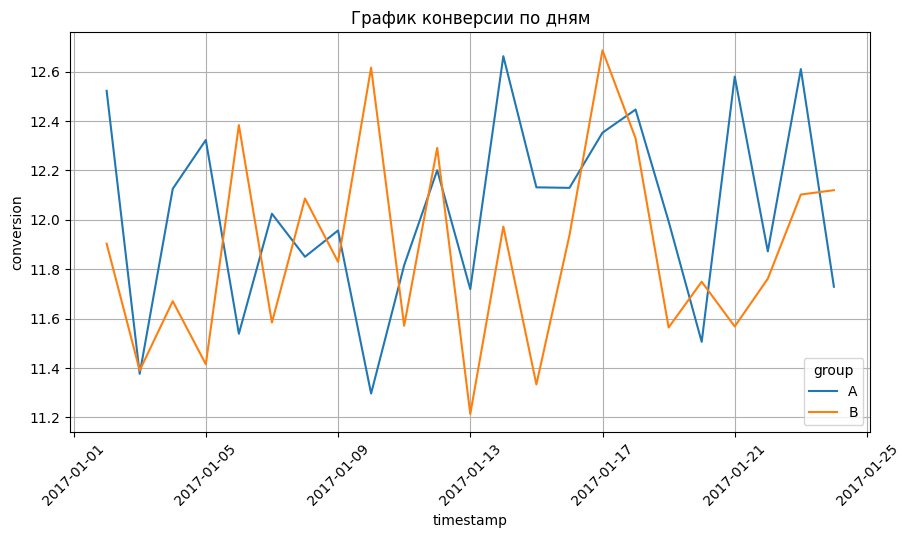

In [10]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше - сложно, поэтому рассмотрим график кумулятивной конверсии. 

Сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted), после этого рассчитаем кумулятивную конверсию.

In [11]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


Построим графики кумулятивной конверсии по дням в каждой группе.

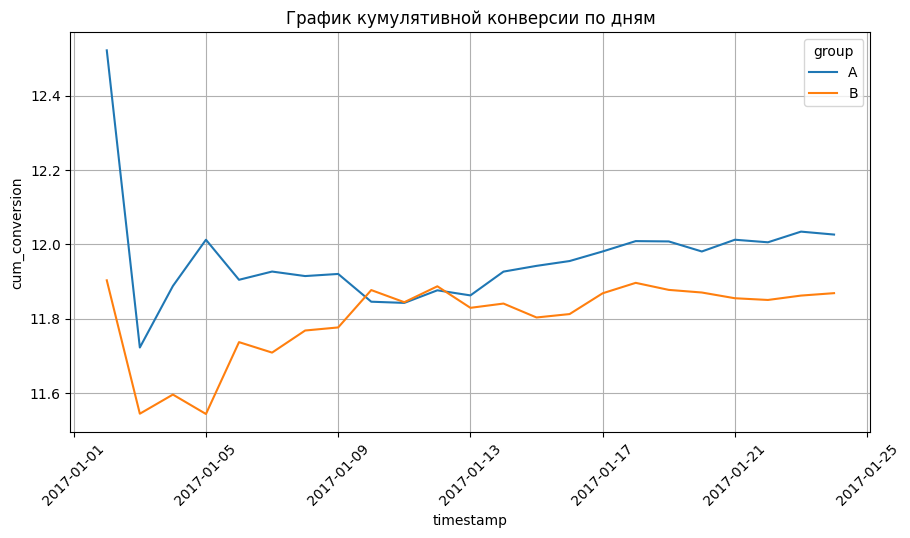

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Сгруппируем данные по признаку группы и рассчитаем количество «успехов» и общее количество наблюдений для каждой группы.

In [13]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


Будем проверять следующую новую гипотезу:
H0: pa = pb - конверсии в группах А и B равны.
При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):
H1 pa > pb - конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости 0.5 и будем сравнивать полученное p-value с ним.

In [14]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Итак, мы получили p-value = 0.1. Оно больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

В контексте задачи A/B-тестирования нам бы хотелось знать истинную конверсию (а не ту, которая подсчитана по выборке) в контрольной и тестовой группе, а также оценить истинную разницу между конверсиями. 

In [15]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

In [18]:
"""
n — размер выборки, x_p — выборочная пропорция и gamma — 
уровень надёжности (по умолчанию он равен 0.95). Функция будет 
возвращать кортеж из вычисленных границ доверительного интервала,
умноженных на 100 % и округлённых до второго знака после запятой.
"""
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Можно сделать вывод, что с надёжностью в 95 % 
* конверсия группы А лежит в интервале от 11.86% до 12.19% 
* конверсия группы B лежит в интервале от 11.7% до 12.03%.

Построим доверительный интервал разницы конверсий.

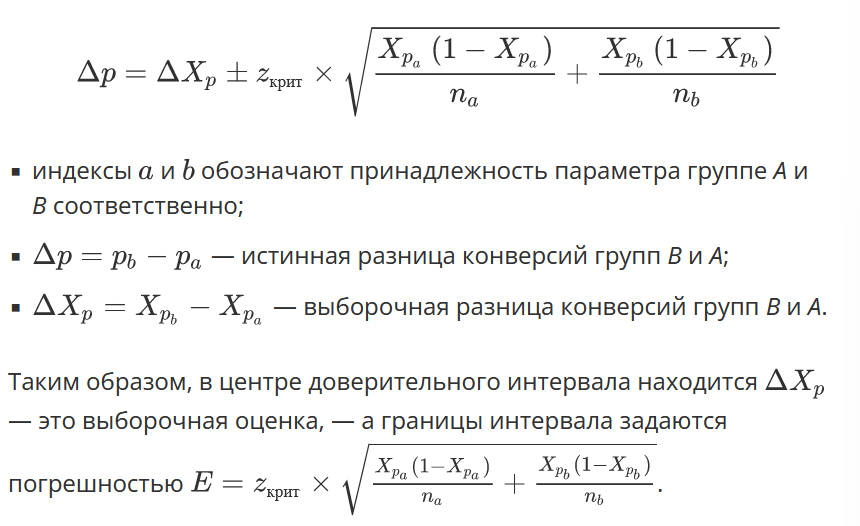

In [19]:
"""
n — список из размеров выборки для групп А и B соответственно, xp — список из
выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности 
"""
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.